In [1]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain-community langchain-openai pymongo[srv]==3.12

In [2]:
from dotenv import load_dotenv
load_dotenv()

True

### Define State

In [3]:
from typing_extensions import TypedDict
from typing import List

class SalesDataResponse(TypedDict):
    """Response structure for sales data queries."""
    count: int
    query: dict
    sales: List[dict]

class QueryExecute(TypedDict):
    input: str
    query: dict
    response: SalesDataResponse
    snow_response: str

### Define tools

In [4]:
from langchain_core.tools import tool
from pymongo import MongoClient
import os
import json
from bson import json_util
from datetime import datetime
import ast

@tool
def get_sales_data(mongo_query: dict = None) -> SalesDataResponse:
    """Get sales data from MongoDB using flexible query parameters.
    
    Args:
        mongo_query: Custom MongoDB query dict to execute directly
    """    
    
    client = None
    try:
        client = MongoClient(os.getenv("MONGODB_URI"))
        database = client.get_database("mongodbVSCodePlaygroundDB")
        collection = database.get_collection("sales")
        
        # Use simple find query (handles $or, $and, $in, $ne, etc.)
        cursor = collection.find(mongo_query if mongo_query else {})
        
        sales_data = list(cursor)
        
        # Convert results to a readable format (handle MongoDB ObjectId and Date objects)
        results = json.loads(json_util.dumps(sales_data))
        
        if not sales_data:
            return f"No sales found for query: {mongo_query}"  
        
        return SalesDataResponse(
            count=len(sales_data),
            query=mongo_query,
            sales=results
        )
    
    except Exception as e:
        return f"Error retrieving sales data: {str(e)}"
    
    finally:
        if client:
            client.close()

In [5]:
# Mock approval/denial API tools
@tool
def approve_request(data: dict):
    """Approve a request based on the given data.
    
    Args:
        data: The data supporting the approval decision
    """
    return f"Request APPROVED with {data['count']} matching records found"

@tool
def deny_request(reason: str):
    """Deny a request with a provided reason.
    
    Args:
        reason: The reason for denial
    """
    return f"Request DENIED. Reason: {reason}"

### Execution agent

In [6]:
from langchain_openai import AzureChatOpenAI
from langgraph.prebuilt import create_react_agent

# Custom prompt for MongoDB query processing
prompt = """
You are a MongoDB query execution agent. 
When provided with a specific MongoDB query, you must execute it exactly as given using the get_sales_data tool.
Do not modify the query - use it exactly as provided.
Return the results from the database query.
"""

# Choose the LLM that will drive the agent
llm = AzureChatOpenAI(
    azure_endpoint=os.environ["AZURE_OPENAI_ENDPOINT"],
    azure_deployment=os.environ["AZURE_OPENAI_DEPLOYMENT_NAME"],
    openai_api_version="2024-12-01-preview",
)

agent_executor = create_react_agent(model=llm, tools=[get_sales_data], prompt=prompt)

### Define MongoDB Query Agent

In [7]:
from langchain_openai import AzureChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from datetime import datetime
        
schema_info = """
    MongoDB Collection Schema:
    {
        'item': string,      // Product identifier like 'abc', 'xyz', etc.
        'price': number,     // Price of the item (e.g., 10, 7.5)
        'quantity': number,  // Number of items sold (e.g., 5, 10)
        'date': Date     // Date of the sale in ISO format 
    }
    """
    
query_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """
            You are a MongoDB query assistant. Based on user requests, generate appropriate MongoDB queries.
        {schema_info}

        Analyze the user query, determine what information they need from the sales data, and formulate a MongoDB query dictionary.
        Your response should be a valid Python dictionary that can be used as a MongoDB query.
        
        IMPORTANT: Return ONLY the Python dictionary without any additional text, markdown formatting, or code blocks.
        
        For date queries in 2014, use this format:
        {{"date": {{"$gte": "2014-01-01T00:00:00.000Z", "$lt": "2015-01-01T00:00:00.000Z"}}}}
        
        For item queries, use this format:
        {{"item": "xyz"}}
        
        For combined queries, use this format:
        {{"item": "xyz", "date": {{"$gte": "2014-01-01T00:00:00.000Z", "$lt": "2015-01-01T00:00:00.000Z"}}}}

        Be specific and precise with your queries. Always use ISO date strings for date comparisons.
    """,
        ),
        ("placeholder", "{messages}"),
    ]
)

query_agent = query_prompt | llm

### Define an SNOW agent

In [8]:
snow_prompt = """
You are an approval agent that decides whether to approve or deny requests based on query results.

Rules:
- If the number of records found is greater than 0, you MUST call the approve_request tool with the data
- If the number of records found is 0, you MUST call the deny_request tool with a reason

Always use the appropriate tool to make your decision. Do not just respond with text.
"""

snow_agent = create_react_agent(model=llm, tools=[approve_request, deny_request], prompt=snow_prompt)

### Define the steps 

In [9]:
import ast

async def mongo_step(state: QueryExecute):
    """Generate MongoDB query based on user input."""

    mongo_response = await query_agent.ainvoke({
        "messages": [("user", state["input"])],
        "schema_info": schema_info 
    })
    
    # Parse the response content as a Python dictionary
    query_str = mongo_response.content.strip()
    query_dict = ast.literal_eval(query_str)
    
    return {"query": query_dict}

async def execute_step(state: QueryExecute):
    """Execute the MongoDB query using the agent executor."""
    
    query = state["query"]
    execution_prompt = f"Execute this exact MongoDB query: {query}. Use the get_sales_data tool with this query and return the results."

    # Use the agent executor with the specific query
    response = await agent_executor.ainvoke({
        "messages": [("user", execution_prompt)]
    })
    
    # Extract tool result from get_sales_data tool call
    for message in response["messages"]:
        if hasattr(message, 'name') and message.name == 'get_sales_data':
            content = message.content
            # Parse JSON string response to dictionary if needed
            if isinstance(content, str) and content.startswith('{'):
                try:
                    content = ast.literal_eval(content)
                except:
                    pass
            return {"response": content}
    
    # Fallback: return the last message content
    return {"response": response["messages"][-1].content}

async def snow_step(state: QueryExecute):
    """Decide whether to approve or deny the request based on the query results."""
    response = state["response"]
    
    # Extract count from response
    count = response.get("count", 0) if isinstance(response, dict) else 0
    
    # Create message based on count
    if count > 0:
        message = f"Found {count} matching records. Approve this request using the approve_request tool with data: {response}"
    else:
        message = f"Found 0 matching records. Deny this request using the deny_request tool with reason: 'No matching records found'"
    
    output = await snow_agent.ainvoke({"messages": [("user", message)]})
    
    return {"snow_response": output["messages"][-1].content}

### Create the Graph

In [10]:
from langgraph.graph import END
from langgraph.graph import StateGraph, START

workflow = StateGraph(QueryExecute)

workflow.add_node("mongo", mongo_step)
workflow.add_node("execute", execute_step)
workflow.add_node("snow", snow_step)

workflow.add_edge(START, "mongo")
workflow.add_edge("mongo", "execute")
workflow.add_edge("execute", "snow")
workflow.add_edge("snow", END)

app = workflow.compile()

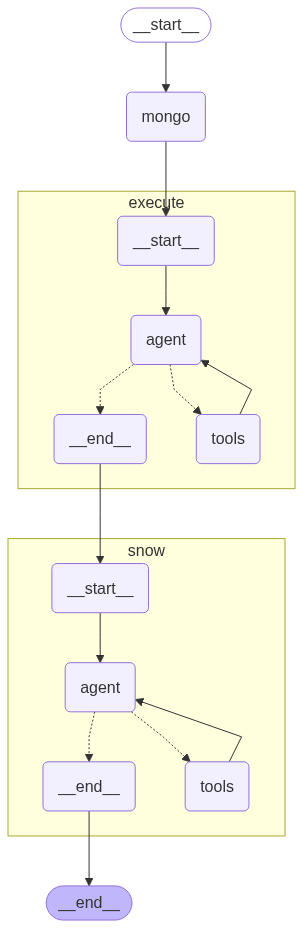

In [11]:
from IPython.display import Image, display

display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [12]:
# Test the agent with some example queries

async def test_query():
    response = await app.ainvoke({"input": "How many xyz items were sold?"})
    print("Full response:")
    print(response)
    print("\nQuery generated:")
    print(response["query"])
    print("\nExecution response:")
    print(response["response"])
    print("\nSNOW response:")
    print(response["snow_response"])
    return response

# Run the async function
await test_query()


Full response:
{'input': 'How many xyz items were sold?', 'query': {'item': 'xyz'}, 'response': {'count': 2, 'query': {'item': 'xyz'}, 'sales': [{'_id': {'$oid': '6837860f55e9e6698ee5a770'}, 'item': 'xyz', 'price': 5, 'quantity': 10, 'date': {'$date': '2014-03-15T09:00:00Z'}}, {'_id': {'$oid': '6837860f55e9e6698ee5a771'}, 'item': 'xyz', 'price': 5, 'quantity': 20, 'date': {'$date': '2014-04-04T11:21:39.736Z'}}]}, 'snow_response': 'The request has been approved with the provided data containing 2 matching records.'}

Query generated:
{'item': 'xyz'}

Execution response:
{'count': 2, 'query': {'item': 'xyz'}, 'sales': [{'_id': {'$oid': '6837860f55e9e6698ee5a770'}, 'item': 'xyz', 'price': 5, 'quantity': 10, 'date': {'$date': '2014-03-15T09:00:00Z'}}, {'_id': {'$oid': '6837860f55e9e6698ee5a771'}, 'item': 'xyz', 'price': 5, 'quantity': 20, 'date': {'$date': '2014-04-04T11:21:39.736Z'}}]}

SNOW response:
The request has been approved with the provided data containing 2 matching records.


{'input': 'How many xyz items were sold?',
 'query': {'item': 'xyz'},
 'response': {'count': 2,
  'query': {'item': 'xyz'},
  'sales': [{'_id': {'$oid': '6837860f55e9e6698ee5a770'},
    'item': 'xyz',
    'price': 5,
    'quantity': 10,
    'date': {'$date': '2014-03-15T09:00:00Z'}},
   {'_id': {'$oid': '6837860f55e9e6698ee5a771'},
    'item': 'xyz',
    'price': 5,
    'quantity': 20,
    'date': {'$date': '2014-04-04T11:21:39.736Z'}}]},
 'snow_response': 'The request has been approved with the provided data containing 2 matching records.'}